<a href="https://colab.research.google.com/github/monya-9/deep-learning-practice/blob/main/08_BatchNorm_LayerNorm_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BatchNorm vs LayerNorm


In [ ]:
# ===========================
# 0. 라이브러리 임포트
# ===========================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===========================
# 1. 데이터셋 준비 (MNIST)
# ===========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 528kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


- MNIST 28x28 흑백 이미지

- Tensor 변환 후 픽셀 정규화

- 배치 단위 DataLoader 생성

In [ ]:
# ===========================
# 2. 모델 정의 (MLP, CNN + BatchNorm/LayerNorm)
# ===========================
class MLP(nn.Module):
    def __init__(self, norm_type=None):
        super(MLP, self).__init__()
        layers = [nn.Flatten(), nn.Linear(28*28, 256)]
        if norm_type=="batch":
            layers.append(nn.BatchNorm1d(256))
        elif norm_type=="layer":
            layers.append(nn.LayerNorm(256))
        layers += [nn.ReLU(), nn.Linear(256, 128)]
        if norm_type=="batch":
            layers.append(nn.BatchNorm1d(128))
        elif norm_type=="layer":
            layers.append(nn.LayerNorm(128))
        layers += [nn.ReLU(), nn.Linear(128, 10)]
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)

class CNN(nn.Module):
    def __init__(self, norm_type=None):
        super(CNN, self).__init__()
        conv_layers = [
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU()
        ]
        if norm_type=="batch":
            conv_layers.append(nn.BatchNorm2d(32))
        elif norm_type=="layer":
            conv_layers.append(nn.GroupNorm(1, 32))  # LayerNorm 대체
        conv_layers += [nn.Conv2d(32, 64, 3, 1), nn.ReLU()]
        if norm_type=="batch":
            conv_layers.append(nn.BatchNorm2d(64))
        elif norm_type=="layer":
            conv_layers.append(nn.GroupNorm(1, 64))
        conv_layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*conv_layers)

        fc_layers = [nn.Flatten(), nn.Linear(9216, 128)]
        if norm_type=="batch":
            fc_layers.append(nn.BatchNorm1d(128))
        elif norm_type=="layer":
            fc_layers.append(nn.LayerNorm(128))
        fc_layers += [nn.ReLU(), nn.Linear(128, 10)]
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

MLP
- norm_type=None → 정규화 없음

- "batch" → BatchNorm1d 적용

- "layer" → LayerNorm 적용

CNN
- Conv2d → Norm → ReLU → Conv2d → Norm → ReLU → MaxPool → Flatten → Linear → Norm → ReLU → Linear → 출력

- BatchNorm2d → 배치 단위 특성 정규화

- LayerNorm 대체 → GroupNorm(1, C) 사용

In [ ]:
# ===========================
# 3. 학습/평가 함수
# ===========================
def train_and_evaluate(model, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list, test_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, pred = torch.max(output, 1)
            correct_train += (pred == target).sum().item()
            total_train += target.size(0)
        train_acc = correct_train / total_train
        train_acc_list.append(train_acc)

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, pred = torch.max(output, 1)
                correct_test += (pred == target).sum().item()
                total_test += target.size(0)
        test_acc = correct_test / total_test
        test_acc_list.append(test_acc)

    return train_acc_list, test_acc_list, train_acc_list[-1], test_acc_list[-1]

- 모델을 GPU/CPU로 이동

- 손실 함수: CrossEntropyLoss (분류용)

- 최적화: Adam

- 학습:

   - optimizer.zero_grad() → 기울기 초기화

   - loss.backward() → 역전파 계산

   - optimizer.step() → 파라미터 업데이트

- 학습/테스트 정확도 계산 및 기록(epoch별)

In [ ]:
# ===========================
# 4. 네 가지 경우 비교
# ===========================
results = {}
accuracy_curve = {}

# MLP
for norm in [None, "batch", "layer"]:
    name = f"MLP_{norm or 'no_norm'}"
    train_curve, test_curve, train_acc, test_acc = train_and_evaluate(MLP(norm))
    results[name] = (train_acc, test_acc)
    accuracy_curve[name] = (train_curve, test_curve)

# CNN
for norm in [None, "batch", "layer"]:
    name = f"CNN_{norm or 'no_norm'}"
    train_curve, test_curve, train_acc, test_acc = train_and_evaluate(CNN(norm))
    results[name] = (train_acc, test_acc)
    accuracy_curve[name] = (train_curve, test_curve)

- MLP / CNN 각각에 대해:

  - 정규화 없음

  - BatchNorm 적용

  - LayerNorm 적용

- 결과: 학습 정확도, 테스트 정확도, epoch별 정확도 곡선 저장

In [ ]:
# ===========================
# 5. 결과 출력
# ===========================
print("== 최종 정확도 ==")
for k, v in results.items():
    print(f"{k}: Train={v[0]*100:.2f}%, Test={v[1]*100:.2f}%")

== 최종 정확도 ==
MLP_no_norm: Train=97.48%, Test=97.20%
MLP_batch: Train=99.09%, Test=97.49%
MLP_layer: Train=97.89%, Test=97.60%
CNN_no_norm: Train=99.63%, Test=98.96%
CNN_batch: Train=99.82%, Test=99.10%
CNN_layer: Train=99.81%, Test=99.06%


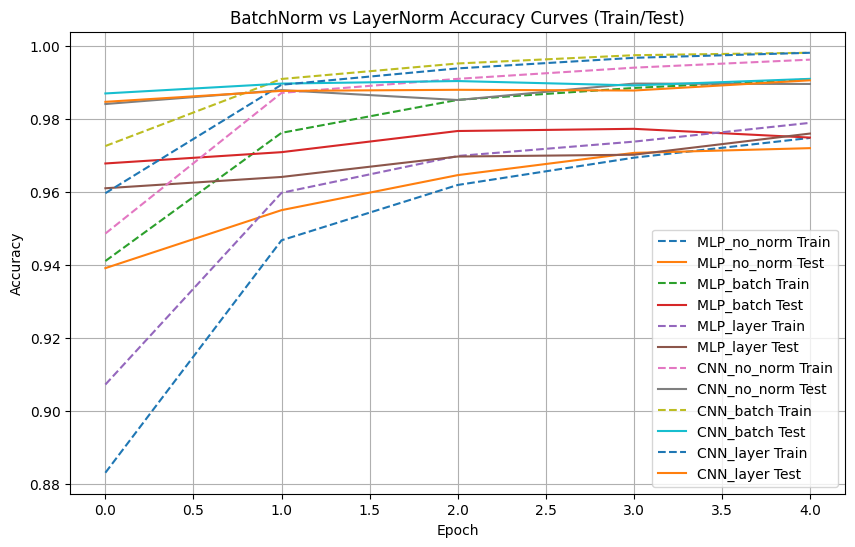

In [ ]:
# ===========================
# 6. 시각화
# ===========================
plt.figure(figsize=(10,6))
for k, v in accuracy_curve.items():
    plt.plot(v[0], '--', label=f"{k} Train")
    plt.plot(v[1], '-', label=f"{k} Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("BatchNorm vs LayerNorm Accuracy Curves (Train/Test)")
plt.legend()
plt.grid(True)
plt.show()

## 🔑 핵심 포인트

1. BatchNorm

  - 배치 단위로 평균/분산 정규화 → 학습 안정화, 학습 속도 향상

2. LayerNorm

  - 특징(feature) 단위 정규화 → RNN이나 작은 배치에서 유리

3. MLP vs CNN

  - MLP: Dense 레이어 위주 → 정규화 효과가 더 명확

  - CNN: Conv 레이어 → BatchNorm이 LayerNorm보다 성능/안정성에서 조금 더 유리할 수 있음